<a href="https://colab.research.google.com/github/hendriansofu/LSTM-Long-Short-Term-Memory-/blob/main/2layer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
import random
import gensim
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [ ]:
df = pd.read_csv('sentiment_labeled_data.csv')

## **Word Embedding**

In [ ]:
sentences = [text.split() for text in df['stemmed_text']]  # Mengubah string menjadi list of tokens

# Latih model Word2Vec pada teks yang ada
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4, sg=0)

# Tokenisasi teks untuk padding dan konversi ke sekuens numerik
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['stemmed_text'])  # Fit tokenizer pada teks yang sudah ter-tokenisasi
sequences = tokenizer.texts_to_sequences(df['stemmed_text'])  # Konversi teks ke sekuens numerik

# Pad sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length)

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

print("Embedding Matrix:")
print(embedding_matrix)


Embedding Matrix:
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.41304403  0.51524179 -0.43610089 ... -0.9341077   0.97049399
  -1.4601033 ]
 [ 0.28112757  0.22578619  0.1111078  ...  0.67541575 -1.48336219
   1.11968248]
 ...
 [ 2.12754711  0.89548704  0.22622232 ... -0.85500865  0.92234703
  -1.05200483]
 [-0.77260568 -0.43059359  0.58514149 ... -1.07271065  0.89453596
   0.10299336]
 [ 2.07078852  0.50316379 -0.39379182 ... -1.30657822 -0.30827769
  -1.4878623 ]]


## **PELATIHAN MODEL & SPLIT**

In [ ]:
# Buat model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(100, return_sequences=True),
    Dropout(0.9),
    LSTM(100),
    Dropout(0.9),
    Dense(1, activation='sigmoid')
])

# Optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment_binary'], test_size=0.3, random_state=42)

# Print summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Menampilkan hasil akhir pelatihan
print("Model training completed.")
print("Final validation accuracy:", history.history['val_accuracy'][-1])
print("Final training loss:", history.history['loss'][-1])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 47, 300)           3145200   
                                                                 
 lstm_40 (LSTM)              (None, 47, 100)           160400    
                                                                 
 dropout_37 (Dropout)        (None, 47, 100)           0         
                                                                 
 lstm_41 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_38 (Dropout)        (None, 100)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3386101 (12.92 MB)
Trainable params: 24

Training history plot saved as 'training_history.png'


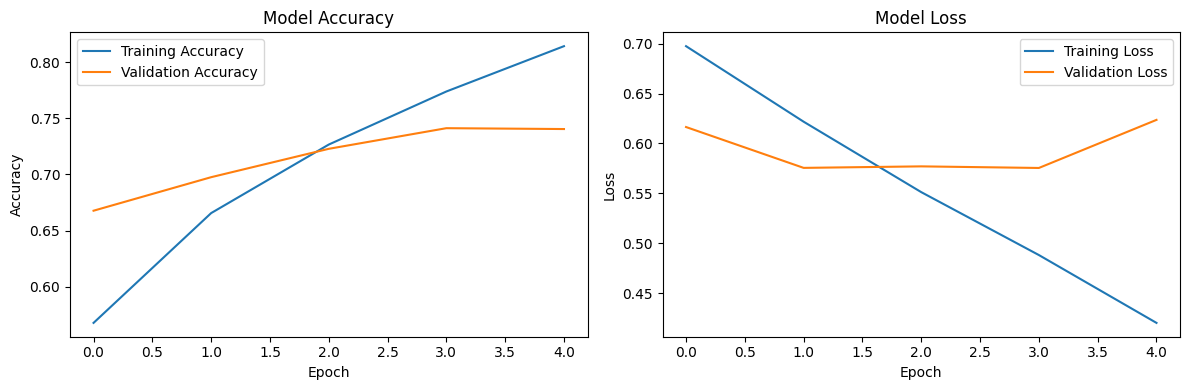

In [ ]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
print("Training history plot saved as 'training_history.png'")



# **Confusion Matrix**

In [ ]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length),
    LSTM(100, return_sequences=True),
    Dropout(0.9),
    LSTM(100),
    Dropout(0.9),
    Dense(1, activation='sigmoid')
])

# Optimizer dengan learning rate yang lebih rendah
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Membuat prediksi
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Evaluasi
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('LSTM Confusion Matrix')
plt.savefig('confusion_matrix_lstm.png')
plt.close()

print("Confusion matrix saved as 'confusion_matrix_lstm.png'")

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1, average='binary')
recall = recall_score(y_test, y_pred, pos_label=1, average='binary')
f1 = f1_score(y_test, y_pred, pos_label=1, average='binary')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Epoch 1/5
96/96 [==============================] - 29s 262ms/step - loss: 0.6907 - accuracy: 0.5753 - val_loss: 0.6146 - val_accuracy: 0.6708
Epoch 2/5
96/96 [==============================] - 19s 197ms/step - loss: 0.6160 - accuracy: 0.6672 - val_loss: 0.5550 - val_accuracy: 0.7236
Epoch 3/5
96/96 [==============================] - 19s 199ms/step - loss: 0.5265 - accuracy: 0.7460 - val_loss: 0.5537 - val_accuracy: 0.7282
Epoch 4/5
96/96 [==============================] - 19s 202ms/step - loss: 0.4232 - accuracy: 0.8162 - val_loss: 0.5958 - val_accuracy: 0.7427
Epoch 5/5
41/41 [==============================] - 3s 57ms/step
Confusion matrix saved as 'confusion_matrix_lstm.png'
Accuracy: 0.75
Precision: 0.68
Recall: 0.62
F1 Score: 0.65
